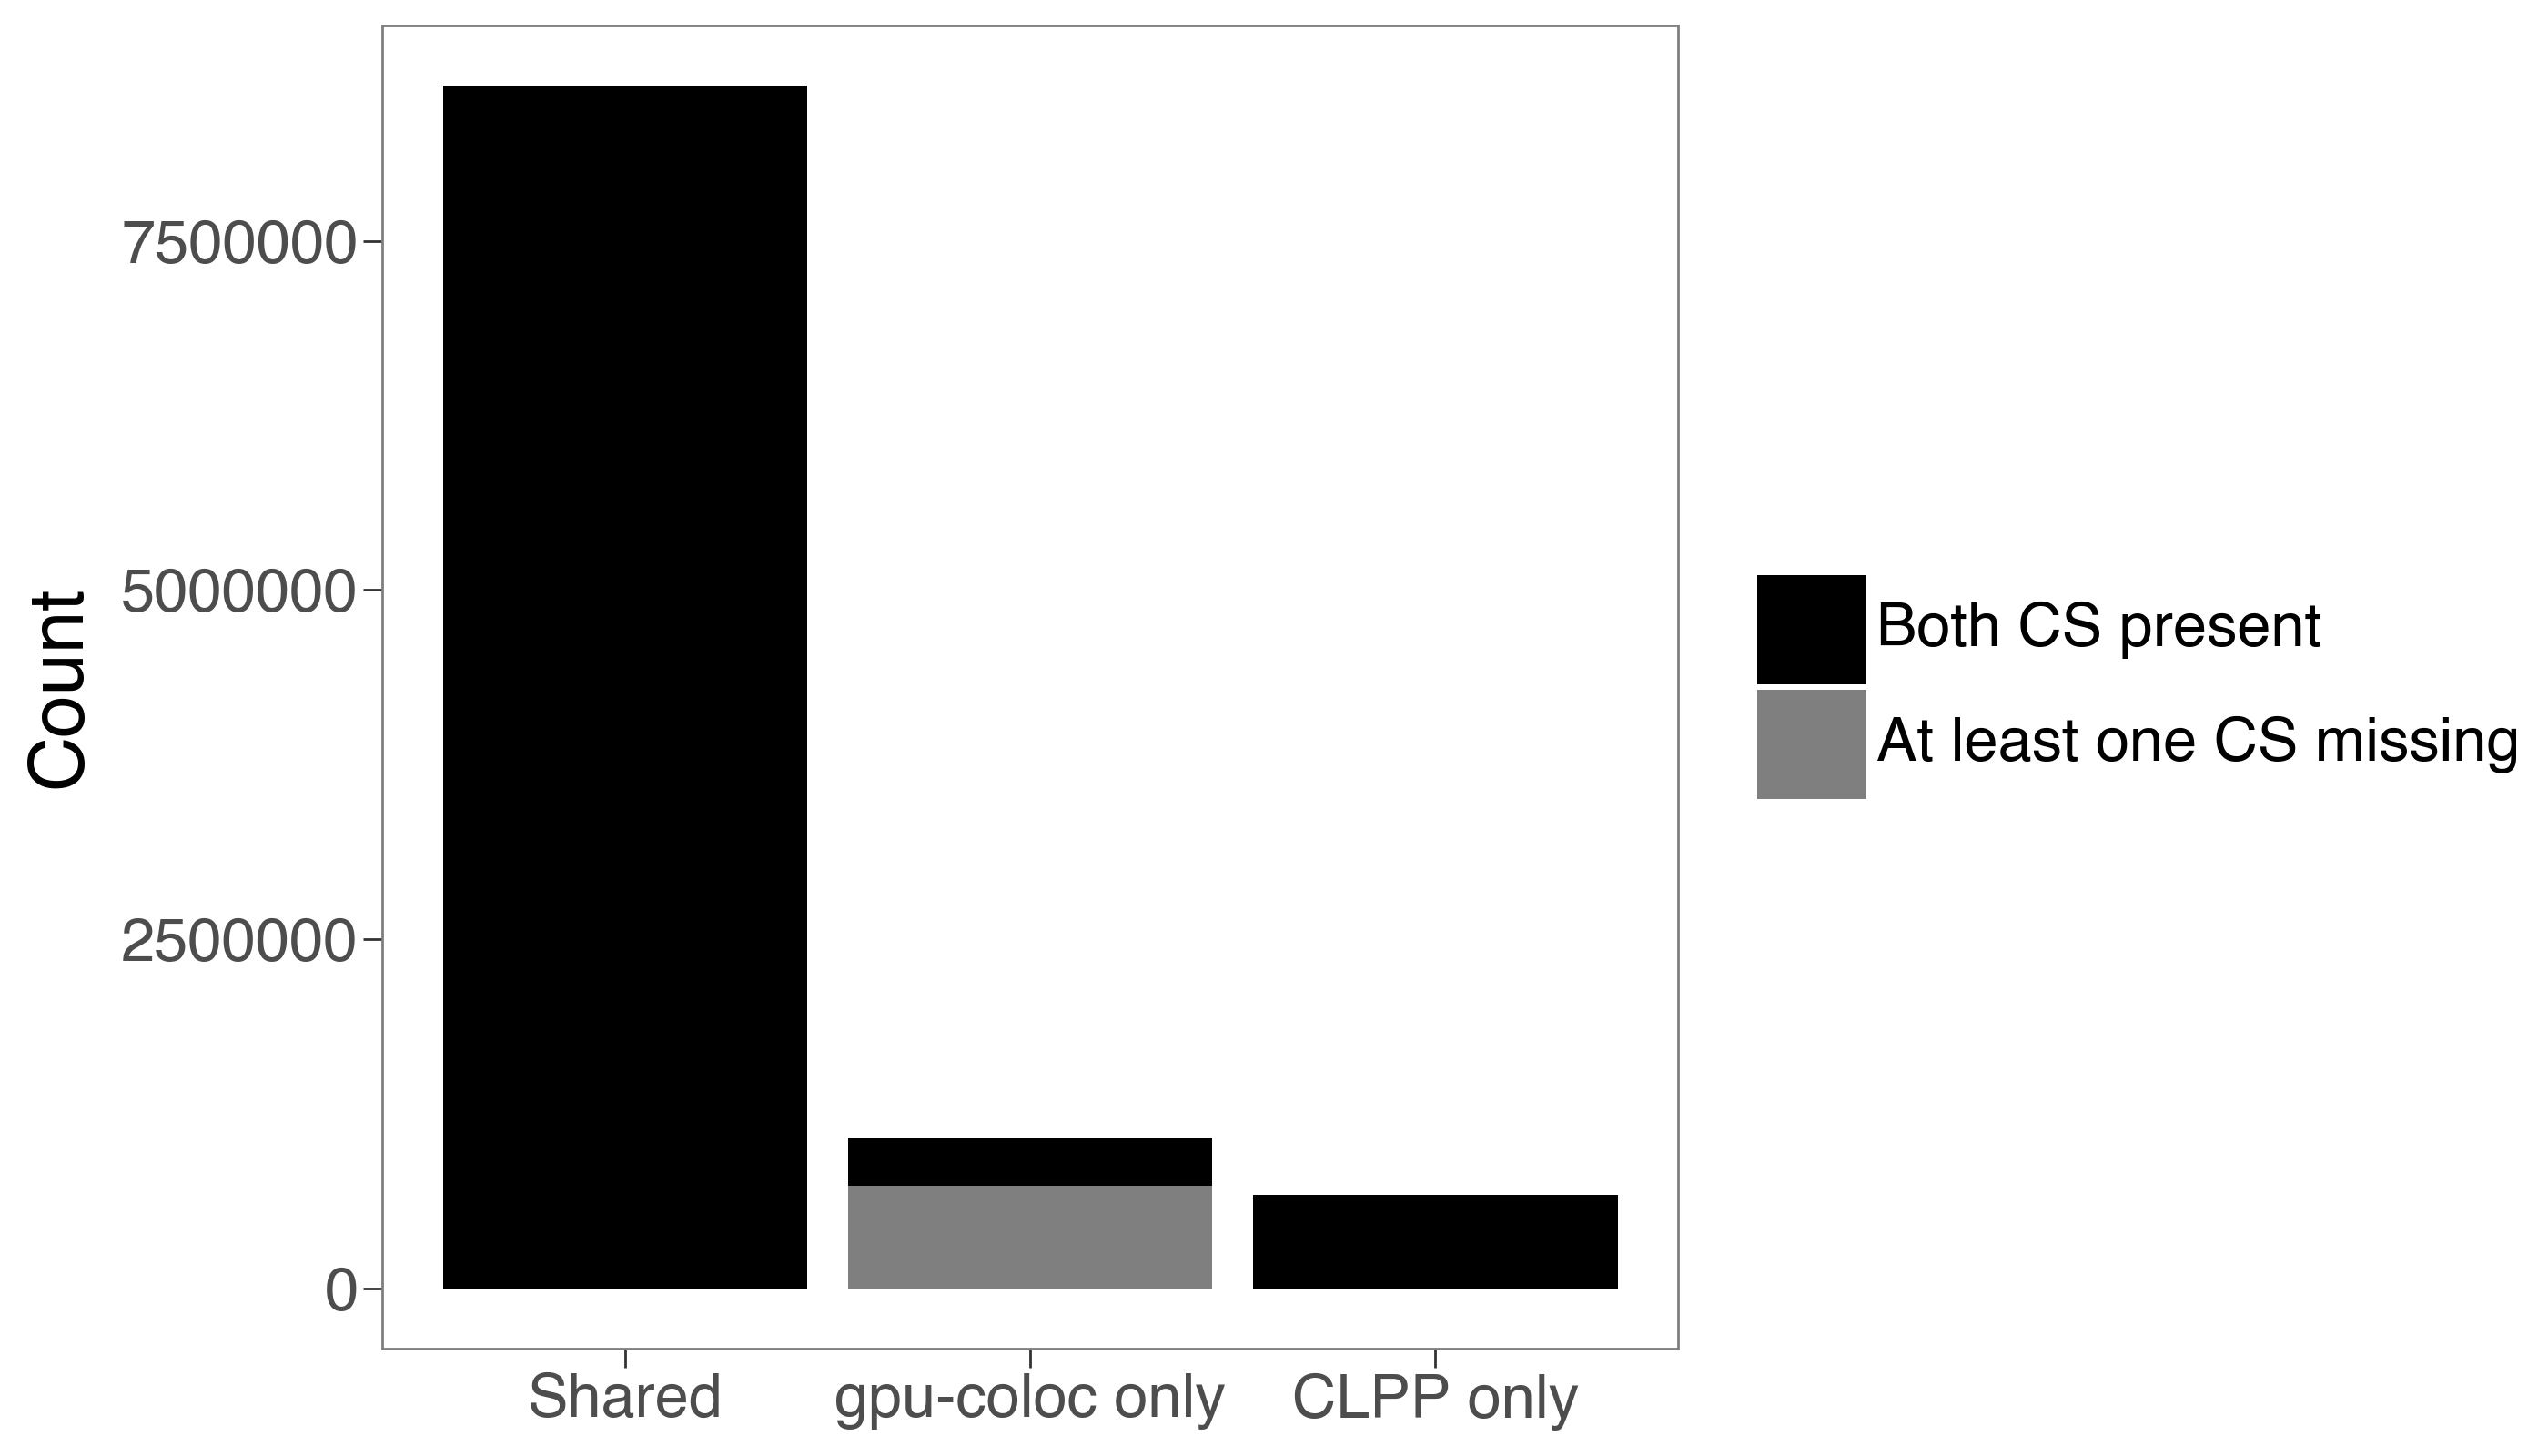

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

p1e6 = pd.read_csv("../data/ge_ge_results_1e-6_0.8.tsv", sep="\t")

p1e6 = p1e6.drop_duplicates(subset=["signal1", "signal2"], keep="first")

clpp = pd.read_csv("../data/ge_ge_clpp.tsv", sep="\t")

clpp = clpp.drop_duplicates(subset=["signal_a", "signal_b"], keep="first")

credible_sets = np.load("../data/FinnGen_and_eQTL_Catalogue_credible_sets.npy", allow_pickle=True).tolist()

clpp = clpp[(clpp["clpp"]>=0.04)]
p1e6 = p1e6[(p1e6["PP.H4"]>=0.8)]

merged = p1e6.merge(clpp, left_on=['signal1', 'signal2'], right_on=['signal_a', 'signal_b'])

p1e6["FinnGen_cs"] = p1e6["signal1"].isin(credible_sets)
p1e6["EQTL_cs"] = p1e6["signal2"].isin(credible_sets)

p1e6["Category"] = "Neither"
p1e6.loc[p1e6["FinnGen_cs"] & p1e6["EQTL_cs"], "Category"] = "Both CS"
p1e6.loc[p1e6["FinnGen_cs"] & ~p1e6["EQTL_cs"], "Category"] = "Only FG CS"
p1e6.loc[~p1e6["FinnGen_cs"] & p1e6["EQTL_cs"], "Category"] = "Only eQTL CS"

category_counts = p1e6["Category"].value_counts()

both_cs_total = category_counts.get("Both CS", 0)
both_cs_in_merged = merged[
    merged["signal1"].isin(p1e6[p1e6["Category"] == "Both CS"]["signal1"]) &
    merged["signal2"].isin(p1e6[p1e6["Category"] == "Both CS"]["signal2"])
].shape[0]
both_cs_not_merged = both_cs_total - both_cs_in_merged

only_clpp = clpp.merge(merged, left_on=['signal_a', 'signal_b'], right_on=['signal1', 'signal2'], how='left', indicator=True)
only_clpp_count = only_clpp[only_clpp['_merge'] == 'left_only'].shape[0]

categories = ["Both CS", "Only FG CS", "Only eQTL CS", "Neither", "Only CLPP"]
both_cs_bar = [both_cs_not_merged, 0, 0, 0, 0]
both_cs_merged_bar = [both_cs_in_merged, 0, 0, 0, 0]
only_fg_bar = [0, category_counts.get("Only FG CS", 0), 0, 0, 0]
only_eqtl_bar = [0, 0, category_counts.get("Only eQTL CS", 0), 0, 0]
neither_bar = [0, 0, 0, category_counts.get("Neither", 0), 0]
only_clpp_bar = [0, 0, 0, 0, only_clpp_count]

shared_both  = both_cs_in_merged               
gpu_both     = both_cs_not_merged              
gpu_missing  = (category_counts.get("Only FG CS", 0) +
                category_counts.get("Only eQTL CS", 0) +
                category_counts.get("Neither", 0)) 
clpp_both    = only_clpp_count      

plot_df = pd.DataFrame({
    "Group" : ["Shared",
               "gpu-coloc only", "gpu-coloc only",
               "CLPP only"],
    "Status": ["Both CS present",
               "Both CS present", "At least one CS missing",
               "Both CS present"],
    "Count" : [shared_both,
               gpu_both, gpu_missing,
               clpp_both]
})

plot_df["Group"] = pd.Categorical(plot_df["Group"],
                                  ["Shared", "gpu-coloc only", "CLPP only"])
plot_df["Status"] = pd.Categorical(plot_df["Status"],
                                   ["Both CS present", "At least one CS missing"])

plot_df["Status"] = pd.Categorical(
    plot_df["Status"],
    ["Both CS present", "At least one CS missing"]
)

from plotnine import (
    ggplot, aes, geom_bar, labs, scale_fill_manual,
    theme_bw, theme, element_text, element_blank
)

plot = (
    ggplot(plot_df, aes("Group", "Count", fill="Status")) +
    geom_bar(stat="identity", width=0.9, position="stack") +

    scale_fill_manual(values={
        "Both CS present": "#000000",      
        "At least one CS missing": "#7f7f7f" 
    }) +

    labs(x="", y="Count") +
    theme_bw(base_size=30) +
    theme(
        figure_size=(14, 8),
        axis_text_x=element_text(
            rotation=0, vjust=1,          
        ),
        panel_grid=element_blank(),            
        legend_title=element_blank()
    )
)

plot

In [3]:
plot_df['Proportion'] = plot_df['Count'] / plot_df['Count'].sum()
plot_df

,Group,Status,Count,Proportion
0,Shared,Both CS present,8609903,0.831397
1,gpu-coloc only,Both CS present,338854,0.032721
2,gpu-coloc only,At least one CS missing,734986,0.070972
3,CLPP only,Both CS present,672208,0.064910


In [4]:
(734986+338854)/(734986+338854+672208)

0.6150117293453559

In [5]:
plot_df["Count"].sum()

np.int64(10355951)

In [6]:
338854+734986

1073840

In [7]:
8609903/(plot_df["Count"].sum()-734986)

np.float64(0.8949105417180085)